In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

In [2]:
###### https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/ #################
# with modifications and GPU acceleration by Mark J Bennett mbennett@nvidia.com
## You can download these from FNMA site or https://docs.rapids.ai/datasets/mortgage-data
###### Best when compared to:
###### https://www.bankofengland.co.uk/-/media/boe/files/working-paper/2019/
######        machine-learning-explainability-in-finance-an-application-to-default-risk-analysis.pdf
import numpy,sys,pandas as pd
numpy.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import time
n_gpus, isPlot = 1, False
if n_gpus == 0:
    from pandas import read_csv,concat,merge,DataFrame,get_dummies,Series,isnull
    from sklearn.preprocessing import OneHotEncoder
    from numpy import zeros,double,int8,concatenate
else:
    from cudf import read_csv,concat,merge,DataFrame,get_dummies,Series
    from cuml.preprocessing import OneHotEncoder
    from cupy import zeros,double,int8,concatenate

In [3]:
!ls ../data/*

../data/mortgage_2000-2016.tgz	../data/rmback.sh
../data/names.csv		../data/rmfront.sh

../data/acq:
Acquisition_2007Q1.txt	Acquisition_2009Q1.txt	Acquisition_2011Q1.txt
Acquisition_2007Q2.txt	Acquisition_2009Q2.txt	Acquisition_2011Q2.txt
Acquisition_2007Q3.txt	Acquisition_2009Q3.txt	Acquisition_2011Q3.txt
Acquisition_2007Q4.txt	Acquisition_2009Q4.txt	Acquisition_2011Q4.txt
Acquisition_2008Q1.txt	Acquisition_2010Q1.txt	Acquisition_2012Q1.txt
Acquisition_2008Q2.txt	Acquisition_2010Q2.txt	Acquisition_2012Q2.txt
Acquisition_2008Q3.txt	Acquisition_2010Q3.txt	Acquisition_2012Q3.txt
Acquisition_2008Q4.txt	Acquisition_2010Q4.txt	Acquisition_2012Q4.txt

../data/perf:
Performance_2007Q1.txt	  Performance_2009Q2.txt_1  Performance_2011Q3.txt
Performance_2007Q2.txt	  Performance_2009Q3.txt_0  Performance_2011Q4.txt_0
Performance_2007Q3.txt	  Performance_2009Q3.txt_1  Performance_2011Q4.txt_1
Performance_2007Q4.txt	  Performance_2009Q4.txt    Performance_2012Q1.txt_0
Performance_2008Q1.txt	  Perfo

In [4]:
import numpy,sys,os, pandas as pd
import time,os,cudf
os.chdir('/rapids/data')
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import OrderedDict
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as mp
%matplotlib inline
col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','Extra','MortInsType','RelMortInd'];
dtypesDict = OrderedDict([
        ("LoanID", "int64"),
        ("Channel", "category"),
        ("SellerName", "category"),
        ("OrInterestRate", "float64"),
        ("OrUnpaidPrinc", "int64"),
        ("OrLoanTerm", "int64"),
        ("OrDate", "str"),
        ("FirstPayment", "str"),
        ("OrLTV", "int64"),#was:float64
        ("OrCLTV", "float64"),
        ("NumBorrow", "float64"),
        ("DTIRat", "float64"),
        ("CreditScore", "float64"),
        ("FTHomeBuyer", "category"),
        ("LoanPurpose", "category"),
        ("PropertyType", "category"),
        ("NumUnits", "int64"),
        ("OccStatus", "category"),
        ("PropertyState", "category"),
        ("Zip", "int64"),
        ("MortInsPerc", "float64"),
        ("ProductType", "category"),
        ("CoCreditScore", "float64"),
        ("Extra", "int64"),
        ("MortInsType", "category"),
        ("RelMortInd", "category"),
    ]) 
dtype = list(dtypesDict.values())
print(dtype)
print('col_acq list is len',len(col_acq))
df_acq = DataFrame()
for yr in [2007,2008,2009,2010,2011,2012]:
    for qtr in [1,2,3,4]:
        print('Acquisition_'+str(yr)+'Q'+str(qtr)+'.txt')
        df_acq_qtr = read_csv('../data/acq/Acquisition_'+str(yr)+'Q'+str(qtr)+'.txt', sep='|',
                              names=col_acq, index_col=False) #dtype=dtype)
        ###if n_gpus == 1: df_acq_qtr.astype(dtypesDict).dtypes
        df_acq = concat([df_acq,df_acq_qtr],axis=0)
        del df_acq_qtr
print(df_acq.shape)
df_acq.head(2)

['int64', 'category', 'category', 'float64', 'int64', 'int64', 'str', 'str', 'int64', 'float64', 'float64', 'float64', 'float64', 'category', 'category', 'category', 'int64', 'category', 'category', 'int64', 'float64', 'category', 'float64', 'int64', 'category', 'category']
col_acq list is len 26
Acquisition_2007Q1.txt
Acquisition_2007Q2.txt
Acquisition_2007Q3.txt
Acquisition_2007Q4.txt
Acquisition_2008Q1.txt
Acquisition_2008Q2.txt
Acquisition_2008Q3.txt
Acquisition_2008Q4.txt
Acquisition_2009Q1.txt
Acquisition_2009Q2.txt
Acquisition_2009Q3.txt
Acquisition_2009Q4.txt
Acquisition_2010Q1.txt
Acquisition_2010Q2.txt
Acquisition_2010Q3.txt
Acquisition_2010Q4.txt
Acquisition_2011Q1.txt
Acquisition_2011Q2.txt
Acquisition_2011Q3.txt
Acquisition_2011Q4.txt
Acquisition_2012Q1.txt
Acquisition_2012Q2.txt
Acquisition_2012Q3.txt
Acquisition_2012Q4.txt
(11232359, 26)


,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrLTV,OrCLTV,NumBorrow,DTIRat,CreditScore,FTHomeBuyer,LoanPurpose,PropertyType,NumUnits,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,Extra,MortInsType,RelMortInd
0,100001461640,R,"PNC BANK, N.A.",6.25,137000,360,01/2007,03/2007,56,56.0,2.0,37.0,741.0,N,C,SF,1,P,MI,486,NaN,FRM,734.0,NaN,N,200701
1,100015135004,R,SUNTRUST MORTGAGE INC.,6.00,116000,360,02/2007,04/2007,80,80.0,2.0,11.0,796.0,N,R,SF,1,S,GA,302,NaN,FRM,762.0,NaN,N,200701


In [5]:
col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','ForeclosureCosts','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator'];
print('col_per list is len',len(col_per),'but using only 2!')
start = time.time()
df_per = DataFrame()
for yr in [2007,2008,2009,2010,2011,2012]:
    for qtr in [1,2,3,4]:
        if yr==2009 and qtr in [1,2,3]: #special for 2009 Q1-Q3
            suffix = '_0'
            fn = '../data/perf/Performance_'+str(yr)+'Q'+str(qtr)+'.txt'+suffix
            print(fn)
            df_per_qtr = read_csv(fn, sep='|',names=col_per, usecols=[0,10],index_col=False)
            suffix = '_1'
        elif yr==2010 and qtr in [4]: #special for 2010 Q4
            suffix = '_0'
            fn = '../data/perf/Performance_'+str(yr)+'Q'+str(qtr)+'.txt'+suffix
            print(fn)
            df_per_qtr = read_csv(fn, sep='|',names=col_per, usecols=[0,10],index_col=False)
            suffix = '_1'   
        elif yr==2011 and qtr in [4]: #special for 2011 Q4
            suffix = '_0'
            fn = '../data/perf/Performance_'+str(yr)+'Q'+str(qtr)+'.txt'+suffix
            print(fn)
            df_per_qtr = read_csv(fn, sep='|',names=col_per, usecols=[0,10],index_col=False)
            suffix = '_1' 
        elif yr==2012 and qtr in [1,2,3,4]: #special for 2012 Q1-Q4
            suffix = '_0'
            fn = '../data/perf/Performance_'+str(yr)+'Q'+str(qtr)+'.txt'+suffix
            print(fn)
            df_per_qtr = read_csv(fn, sep='|',names=col_per, usecols=[0,10],index_col=False)
            suffix = '_1'    
        elif yr==2013 and qtr in [1,2,3]: #special for 2012 Q1-Q4
            suffix = '_0'
            fn = '../data/perf/Performance_'+str(yr)+'Q'+str(qtr)+'.txt'+suffix
            print(fn)
            df_per_qtr = read_csv(fn, sep='|',names=col_per, usecols=[0,10],index_col=False)
            suffix = '_1'                    
        else:
            suffix = ''
        fn = '../data/perf/Performance_'+str(yr)+'Q'+str(qtr)+'.txt'+suffix
        print(fn)
        df_per_qtr = read_csv(fn, sep='|',names=col_per, usecols=[0,10],index_col=False)
        df_per_qtr['CLDS'] = df_per_qtr['CLDS'].astype(str)
        df_per = concat([df_per,df_per_qtr],axis=0)
        del df_per_qtr
print(time.time()-start,'secs')
tread = time.time()-start
print(df_per.shape)
df_per.loc[df_per['LoanID'] == 100006270289].tail(10) #,100960628290]].tail(10)

col_per list is len 31 but using only 2!
../data/perf/Performance_2007Q1.txt
../data/perf/Performance_2007Q2.txt
../data/perf/Performance_2007Q3.txt
../data/perf/Performance_2007Q4.txt
../data/perf/Performance_2008Q1.txt
../data/perf/Performance_2008Q2.txt
../data/perf/Performance_2008Q3.txt
../data/perf/Performance_2008Q4.txt
../data/perf/Performance_2009Q1.txt_0
../data/perf/Performance_2009Q1.txt_1
../data/perf/Performance_2009Q2.txt_0
../data/perf/Performance_2009Q2.txt_1
../data/perf/Performance_2009Q3.txt_0
../data/perf/Performance_2009Q3.txt_1
../data/perf/Performance_2009Q4.txt
../data/perf/Performance_2010Q1.txt
../data/perf/Performance_2010Q2.txt
../data/perf/Performance_2010Q3.txt
../data/perf/Performance_2010Q4.txt_0
../data/perf/Performance_2010Q4.txt_1
../data/perf/Performance_2011Q1.txt
../data/perf/Performance_2011Q2.txt
../data/perf/Performance_2011Q3.txt
../data/perf/Performance_2011Q4.txt_0
../data/perf/Performance_2011Q4.txt_1
../data/perf/Performance_2012Q1.txt_0
.

,LoanID,CLDS
130,100006270289,0
131,100006270289,-1
132,100006270289,0
133,100006270289,0
134,100006270289,0
135,100006270289,0
136,100006270289,1
137,100006270289,2
138,100006270289,3
139,100006270289,4


In [6]:
print(df_per.shape)
df_per = df_per.dropna(subset=['CLDS'])
df_per['CLDS'] = df_per['CLDS'].astype(str)
print(df_per.shape)
df_per.loc[df_per['LoanID']==100006270289].tail(10) #100960628290].tail(10)

(431097211, 2)
(431097211, 2)


,LoanID,CLDS
130,100006270289,0
131,100006270289,-1
132,100006270289,0
133,100006270289,0
134,100006270289,0
135,100006270289,0
136,100006270289,1
137,100006270289,2
138,100006270289,3
139,100006270289,4


In [7]:
df_delinq4 = df_per.loc[df_per['CLDS']=='4']
#df_per    = df_per.loc[df_per.groupby(['LoanID']).CLDS.max()]
print(df_delinq4.shape)
df_delinq4.drop_duplicates(subset='LoanID', keep='last', inplace=True)
print(df_delinq4.shape)
df_delinq4.loc[df_delinq4['LoanID']==100006270289].tail(10) #100960628290].tail(10)

(678250, 2)
(403068, 2)


/home/drew/miniconda/envs/rapids-21.10/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,LoanID,CLDS
139,100006270289,4


In the performance data, we are really only interested in the LoanID and CLDS columns, as this will give us the borrower identifiaction number and whether or not they are delinquent. After reading in the two datasets, we can determine if they are more than 90 days past due with a '4' in the current loan delinquincy status (CLDS) column, then perform an outer join on the acquisition and performance dataframes using the LoanID column. The resulting dataframe, df, will contain the CLDS column, and will be our target variable. For clarity, we will also rename this column as Default.

In the Default column, a 1 is placed next to any borrower that was found to have defaulted, and a 0 is placed next to any borrower that has not defaulted.

In [8]:
print(df_acq.shape,df_delinq4.shape)

start = time.time()
df = merge(df_acq, df_delinq4, on='LoanID', how='outer')
print(time.time()-start,'secs')
tmerg = time.time()-start
del df_acq
del df_per
del df_delinq4

#df = pd.merge(df_acq, df_per, on='LoanID', how='inner')
#df = df.reset_index().rename(columns={'ForeclosureDate': 'Default'})
df = df.reset_index().rename(columns={'CLDS': 'Default'})

print(df.shape)

df.loc[df['Default'] == '4', 'Default'] = 1
df.loc[df['Default'].isnull(), 'Default'] = 0 #for null caused by outer join

#df.a.isnull()

df['Default'] = df['Default'].astype(int)
df.loc[df['LoanID']==100006270289].tail(10) #Yes missed payments and so w/100960628290

(11232359, 26) (403068, 2)
4.582857131958008 secs
(11232359, 28)


,index,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrLTV,OrCLTV,NumBorrow,DTIRat,CreditScore,FTHomeBuyer,LoanPurpose,PropertyType,NumUnits,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,Extra,MortInsType,RelMortInd,Default
1246501,1246501,100006270289,C,"WELLS FARGO BANK, N.A.",7.5,226000,360,11/2007,01/2008,95,95.0,1.0,42.0,704.0,Y,P,SF,1,P,CA,933,30.0,FRM,NaN,1.0,N,200801,1


In [9]:
df['Default'].value_counts()
#Test no default  case:
df.loc[df['LoanID']==100010079393]

,index,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrLTV,OrCLTV,NumBorrow,DTIRat,CreditScore,FTHomeBuyer,LoanPurpose,PropertyType,NumUnits,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,Extra,MortInsType,RelMortInd,Default
5085713,5085713,100010079393,C,"WELLS FARGO BANK, N.A.",4.875,284000,360,01/2010,03/2010,80,80.0,1.0,32.0,773.0,Y,P,PU,1,P,TX,787,NaN,FRM,NaN,NaN,N,201001,0


In [10]:
df.loc[df['Default'] == 1].head(10) #focus on rearer defaults

,index,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrLTV,OrCLTV,NumBorrow,DTIRat,CreditScore,FTHomeBuyer,LoanPurpose,PropertyType,NumUnits,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,Extra,MortInsType,RelMortInd,Default
0,0,100001461640,R,"PNC BANK, N.A.",6.250,137000,360,01/2007,03/2007,56,56.0,2.0,37.0,741.0,N,C,SF,1,P,MI,486,NaN,FRM,734.0,NaN,N,200701,1
4,4,100030521552,C,"GMAC MORTGAGE, LLC",5.875,385000,360,12/2006,03/2007,70,70.0,2.0,50.0,720.0,N,C,SF,1,P,CA,917,NaN,FRM,700.0,NaN,N,200701,1
14,14,100063382477,C,"GMAC MORTGAGE, LLC",6.125,374000,360,01/2007,04/2007,74,74.0,2.0,53.0,658.0,N,C,SF,1,P,NY,115,NaN,FRM,675.0,NaN,N,200701,1
21,21,100115095195,C,"GMAC MORTGAGE, LLC",6.750,125000,180,12/2006,02/2007,44,44.0,1.0,20.0,664.0,N,C,SF,1,P,CA,923,NaN,FRM,NaN,NaN,N,200701,1
43,43,100207041593,C,FLAGSTAR CAPITAL MARKETS CORPORATION,6.625,79000,360,12/2006,02/2007,62,62.0,1.0,62.0,620.0,N,C,SF,1,P,KY,425,NaN,FRM,NaN,NaN,N,200701,1
46,46,100214993651,C,"BANK OF AMERICA, N.A.",6.125,200000,360,12/2006,02/2007,78,78.0,1.0,NaN,748.0,N,P,PU,1,P,NC,274,NaN,FRM,NaN,NaN,N,200701,1
50,50,100247160560,B,"BANK OF AMERICA, N.A.",6.750,88000,360,12/2006,02/2007,95,95.0,2.0,34.0,597.0,N,P,SF,1,P,IN,469,30.0,FRM,610.0,1.0,N,200701,1
57,57,100270354892,R,"CITIMORTGAGE, INC.",6.250,116000,240,12/2006,02/2007,73,73.0,2.0,39.0,671.0,N,C,SF,1,P,OH,450,NaN,FRM,655.0,NaN,N,200701,1
58,58,100271042506,R,OTHER,5.250,245000,360,12/2006,02/2007,61,61.0,2.0,40.0,690.0,N,C,SF,1,P,PR,9,NaN,FRM,658.0,NaN,N,200701,1
62,62,100280661630,B,"BANK OF AMERICA, N.A.",6.750,167000,360,01/2007,03/2007,88,88.0,2.0,54.0,699.0,N,C,SF,1,P,IL,601,25.0,FRM,631.0,1.0,N,200701,1


Before filling in missing values, let’s first take a quick look at the distribution of values in several of the data columns. We can start with our target variable, Default.

In [11]:
nullHistogram = None
if n_gpus == 0:
    nullHistogram = df.apply(lambda x: x.isnull().sum(), axis=0)
nullHistogram

index                   0
LoanID                  0
Channel                 0
SellerName              0
OrInterestRate          3
OrUnpaidPrinc           0
OrLoanTerm              0
OrDate                  0
FirstPayment            0
OrLTV                   0
OrCLTV                633
NumBorrow             513
DTIRat             101342
CreditScore         10725
FTHomeBuyer             0
LoanPurpose             0
PropertyType            0
NumUnits                0
OccStatus               0
PropertyState           0
Zip                     0
MortInsPerc       9863571
ProductType             0
CoCreditScore     5057639
Extra             9863571
MortInsType             0
RelMortInd              0
Default                 0
dtype: int64

In [12]:
if n_gpus == 0 and isPlot:
    sns.countplot(df['Default'])
    vc = df['Default'].value_counts() #Let's see the imbalance 
    print('default density = ',vc[1]/vc[0],"or 1 in",np.round(vc[0]/vc[1],1))
    vc

In [13]:
if n_gpus == 0 and isPlot:
    columns = ['OrInterestRate','OrCLTV','DTIRat','CreditScore','OrUnpaidPrinc']
    fig, axes = mp.subplots(nrows=2, ncols=3, figsize=(8,7))
    mp.tight_layout(w_pad=3.0, h_pad=3.0)

    print(range(1,len(columns)+1), columns)
    for i, column in zip(range(1,len(columns)+1), columns):
        mp.subplot(3,3,i)
        print(i,column)
        print(len(df["Default"]));print(len(df[column]))
        sns.boxplot(x="Default", y=column, data=df, linewidth=0.5)
        mp.xlabel('Default')

In [14]:
df.columns

Index(['index', 'LoanID', 'Channel', 'SellerName', 'OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrDate', 'FirstPayment', 'OrLTV', 'OrCLTV', 'NumBorrow', 'DTIRat', 'CreditScore', 'FTHomeBuyer', 'LoanPurpose', 'PropertyType', 'NumUnits', 'OccStatus', 'PropertyState', 'Zip', 'MortInsPerc', 'ProductType', 'CoCreditScore', 'Extra', 'MortInsType', 'RelMortInd', 'Default'], dtype='object')

In [15]:
df.drop(['index','OrDate','OrLTV','MortInsPerc','RelMortInd','FirstPayment'], axis=1, inplace=True)

#New rule to save GPU memory Aug15: removing PropertyState saves df width
df.drop(['Zip','PropertyState'], axis=1, inplace=True)
print(df.shape)
##############df['Zip'] = df['Zip'].astype('object')

(11232359, 20)


Pick reasonable values for null field values: mode or mean.

In [16]:
def fillnan(df):
    if n_gpus == 0: columns = df.columns[df.isnull().any().tolist()]
    else: columns = df.columns[df.isnull().any().to_arrow().to_pylist()]
    for name in columns:
        print(name)
        if df[name].dtype == 'object':
            df.loc[df[name].isnull(), name] = df[name].mode()
        else:
            df.loc[df[name].isnull(), name] = df[name].mean()
    return df

In [17]:
df = fillnan(df)

OrInterestRate
OrCLTV
NumBorrow
DTIRat
CreditScore
CoCreditScore
Extra


Let’s define a function to get dummy variables for the categorical columns having data type ‘object’.

In [18]:
#import pandas as pd
#unit test run:
if False:
    pdf = pd.DataFrame({'angles': [0, 3, 4, 1],
                     'degrees': [360, 180, 360, 270],
                     'shapes': ['circle', 'triangle', 'rectangle', 'circle'],
                     'ch': ['a','b','c','c']})
    #pdf["grade"] = pdf["grade"].astype("category")
    gdf = cudf.DataFrame.from_pandas(pdf)
    cudf.get_dummies(gdf)

In [19]:
###was: df = getOneHotEncoding(df)
df = get_dummies(df)
print(df.shape)
print('other has',['orig_channel', 'seller_name', 'orig_date', 'first_pay_date', 'first_home_buyer', 'loan_purpose',
 'property_type', 'occupancy_status', 'property_state', 'product_type', 'relocation_mortgage_indicator'])
print(df.shape)
df.tail(2)

(11232359, 82)
other has ['orig_channel', 'seller_name', 'orig_date', 'first_pay_date', 'first_home_buyer', 'loan_purpose', 'property_type', 'occupancy_status', 'property_state', 'product_type', 'relocation_mortgage_indicator']
(11232359, 82)


,LoanID,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra,Default,Channel_B,Channel_C,Channel_R,SellerName_ALLY BANK,SellerName_AMERISAVE MORTGAGE CORPORATION,SellerName_AMTRUST BANK,"SellerName_BANK OF AMERICA, N.A.",SellerName_BISHOPS GATE RESIDENTIAL MORTGAGE TRUST,"SellerName_CASHCALL, INC.",SellerName_CHASE HOME FINANCE,SellerName_CHASE HOME FINANCE (CIE 1),SellerName_CHASE HOME FINANCE FRANKLIN AMERICAN MORTGAGE COMPANY,"SellerName_CHASE HOME FINANCE, LLC",SellerName_CHICAGO MORTGAGE SOLUTIONS DBA INTERBANK MORTGAGE COMPANY,SellerName_CHICAGO MORTGAGE SOLUTIONS DBA INTERFIRST MORTGAGE COMPANY,"SellerName_CITIMORTGAGE, INC.","SellerName_CITIZENS BANK, NATIONAL ASSOCIATION","SellerName_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",SellerName_FEDERAL HOME LOAN BANK OF CHICAGO,SellerName_FIFTH THIRD BANK,SellerName_FIRST TENNESSEE BANK NATIONAL ASSOCIATION,SellerName_FLAGSTAR CAPITAL MARKETS CORPORATION,SellerName_FRANKLIN AMERICAN MORTGAGE COMPANY,SellerName_FREEDOM MORTGAGE CORP.,SellerName_FREMONT BANK,"SellerName_GMAC MORTGAGE, LLC","SellerName_GMAC MORTGAGE, LLC (USAA FEDERAL SAVINGS BANK)","SellerName_HOMEWARD RESIDENTIAL, INC.","SellerName_HSBC BANK USA, NATIONAL ASSOCIATION","SellerName_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","SellerName_METLIFE BANK, NA",SellerName_METLIFE HOME LOANS LLC,SellerName_NEW YORK COMMUNITY BANK,"SellerName_NYCB MORTGAGE COMPANY, LLC",SellerName_OTHER,SellerName_PENNYMAC CORP.,SellerName_PHH MORTGAGE CORPORATION,SellerName_PHH MORTGAGE CORPORATION (USAA FEDERAL SAVINGS BANK),"SellerName_PNC BANK, N.A.","SellerName_PROVIDENT FUNDING ASSOCIATES, L.P.",SellerName_QUICKEN LOANS INC.,SellerName_REGIONS BANK,"SellerName_SANTANDER BANK, NATIONAL ASSOCIATION","SellerName_STEARNS LENDING, LLC",SellerName_SUNTRUST MORTGAGE INC.,SellerName_THE BRANCH BANKING AND TRUST COMPANY,SellerName_THE HUNTINGTON NATIONAL BANK,SellerName_THIRD FEDERAL SAVINGS AND LOAN,SellerName_U.S. BANK N.A.,"SellerName_UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNITED WHOLESALE MORTGAGE","SellerName_WELLS FARGO BANK, NA","SellerName_WELLS FARGO BANK, N.A.",FTHomeBuyer_N,FTHomeBuyer_U,FTHomeBuyer_Y,LoanPurpose_C,LoanPurpose_P,LoanPurpose_R,LoanPurpose_U,PropertyType_CO,PropertyType_CP,PropertyType_MH,PropertyType_PU,PropertyType_SF,OccStatus_I,OccStatus_P,OccStatus_S,ProductType_FRM,MortInsType_N,MortInsType_Y
11232357,999998463129,3.25,70000,360,16.0,2.0,14.0,797.0,1,756.000000,1.077555,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0
11232358,999999788486,3.50,337000,360,46.0,1.0,21.0,800.0,1,766.868035,1.077555,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0


Okay, before we start predicting defaults, let’s balance the classes.  Simply oversampling the the minority class is fine.

### Predicting Delinquent Loans

Alright, now we’re ready to make some predictions! We first randomly split the data into a training set and a test set using the Scikit-Learn train_test_split_function. From these two sets, we idenfiy the target (“Default”) vector, and feature arrays.

In [20]:
import cupy
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
y = df['Default'].values
X = df.drop(['Default','LoanID'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
del X,y

print(type(X_train),type(y_train))
print(X_train.shape,y_train.shape)
ros = RandomOverSampler(sampling_strategy=.93) #Apply to only X_train, y_train
X_train, y_train = ros.fit_resample(cupy.asnumpy(X_train), cupy.asnumpy(y_train))
#sm = SMOTEENN()
#X_train, y_train = sm.fit_sample(cupy.asnumpy(X_train), cupy.asnumpy(y_train))

######X_test, y_test = cupy.asnumpy(X_test), cupy.asnumpy(y_test)
print(type(X_train),type(y_train))
print(X_train.shape,y_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(8424269, 80) (8424269,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(15675218, 80) (15675218,)


In [21]:
#Find col names:
y = df['Default'] #no .values
X = df.drop(['Default','LoanID'], axis=1) #no .values
Xcolumns = df.columns.tolist()
Xcolumns.remove('Default')
Xcolumns.remove('LoanID')

In [22]:
## XGB Training and Inference
print('Start Training')
import cupy, xgboost as xgb
start = time.time()
if n_gpus == 0:
    #model.fit(X_train,y_train)
    model = xgb.train({"num_boost_round": 500, "learning_rate": 0.01, "max_depth":10},
            ###del:xgb.DMatrix(cupy.asnumpy(X_train),label=cupy.asnumpy(y_train)))#,num_boost_round=500)
            xgb.DMatrix(X_train,label=y_train))#,num_boost_round=500)
else:
    #model.fit(cupy.asnumpy(X_train), cupy.asnumpy(y_train))
    model = xgb.train({"num_boost_round": 500, "learning_rate": 0.01, "max_depth":10, "tree_method":"gpu_hist"},
            #{'subsample': 0.81, 'min_child_weight': 0.050100000000000006, 'max_depth': 12,
            #'learning_rate': 0.2505, 'gamma': 15.0, 
            #'colsample_bytree': 0.4, 'colsample_bylevel': 0.0},
            ###del:xgb.DMatrix(cupy.asnumpy(X_train),label=cupy.asnumpy(y_train))) #,num_boost_round=500)
            xgb.DMatrix(X_train,label=y_train))#,num_boost_round=500)
print(type(model))
print(time.time()-start,'secs time for Training')
ttrain = time.time()-start
start = time.time()
#Alternative equivalent ways to predict()
#was: probs = model.predict_proba(X_test)[:,1]
xtest = xgb.DMatrix(X_test)
probs = model.predict(xtest, pred_contribs=False).round(2)

print(time.time()-start,'secs time for Inferencing')
tpred = time.time()-start

Start Training
[16:39:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1633529757631/work/src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


<class 'xgboost.core.Booster'>
134.01005029678345 secs time for Training
0.9812343120574951 secs time for Inferencing


In [23]:
threshold = .535
y_pred = (probs > threshold) # <=================== settable was: .85
print("Classification Report for XGBoost Classifier: \n", classification_report(cupy.asnumpy(y_test), y_pred))
print("Confusion Matrix of XGBoost Classifier: \n", confusion_matrix(cupy.asnumpy(y_test), y_pred))

Classification Report for XGBoost Classifier: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97   2707416
           1       0.31      0.46      0.37    100674

    accuracy                           0.94   2808090
   macro avg       0.64      0.71      0.67   2808090
weighted avg       0.96      0.94      0.95   2808090

Confusion Matrix of XGBoost Classifier: 
 [[2603372  104044]
 [  53889   46785]]


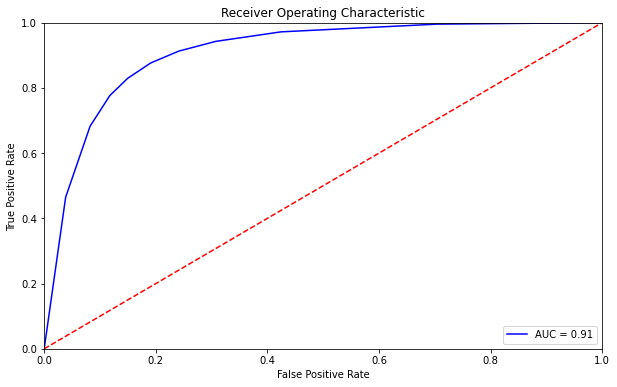

0.9094834015884761

In [24]:
import sklearn.metrics as metrics
#was:probs = model.predict_proba(X_test)
preds = probs
#was:preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(cupy.asnumpy(y_test), preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

roc_auc

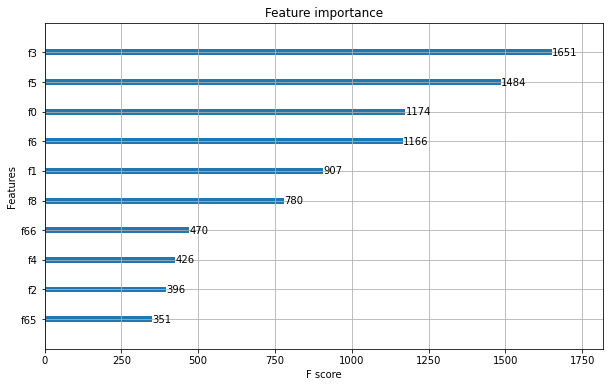

In [25]:
from xgboost import plot_importance
x = plt.rcParams["figure.figsize"] = [10,6]
plot_importance(model,max_num_features=10)

if False:
    from operator import itemgetter
    b = [3,6,0,5,1,8,2,65,64,4]
    l = list(itemgetter(*b)(Xcolumns))
    print(l[0:5],'\n',l[5:10])

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function for plotting Precision Recall curve and measuring AUC
def plot_precision_recall(y_test: np.array, y_score: np.array, isPR = True) -> None:
    #print(y_test[0:20],y_score[0:20])
    precision, recall, _ = precision_recall_curve(y_test, y_score) if isPR else roc_curve(y_test, y_score)
    auc_score = auc(recall, precision)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.85, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: AUC={0:0.4f}'.format(auc_score))
    plt.show()

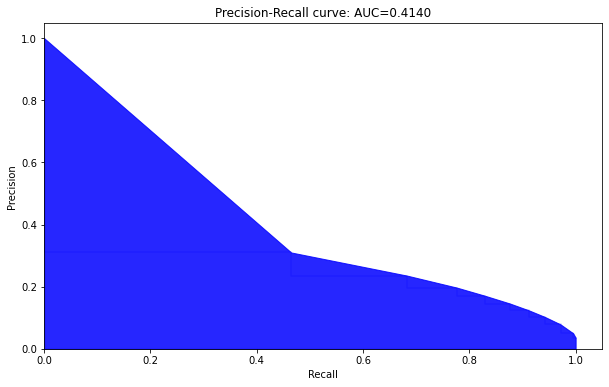

In [27]:
from sklearn.metrics import roc_curve, auc, \
                            precision_recall_curve, classification_report, \
                            confusion_matrix
plt.rcParams["figure.figsize"] = [10,6]
plot_precision_recall(cupy.asnumpy(y_test), probs)

Here is the key step of computing GPU-accelerated Shapley values for all rows.

In [28]:
import pandas as pd, shap
X_test_df = DataFrame(data=cupy.asnumpy(X_test),columns=Xcolumns)
y_test    = DataFrame(data=cupy.asnumpy(y_test),columns=['Default'])
print(X_test_df.shape,type(X_test_df))

(2808090, 80) <class 'pandas.core.frame.DataFrame'>


n_gpus 0
264.9661486148834 secs time
264.96611404418945
(2808090, 80)
1.4.2


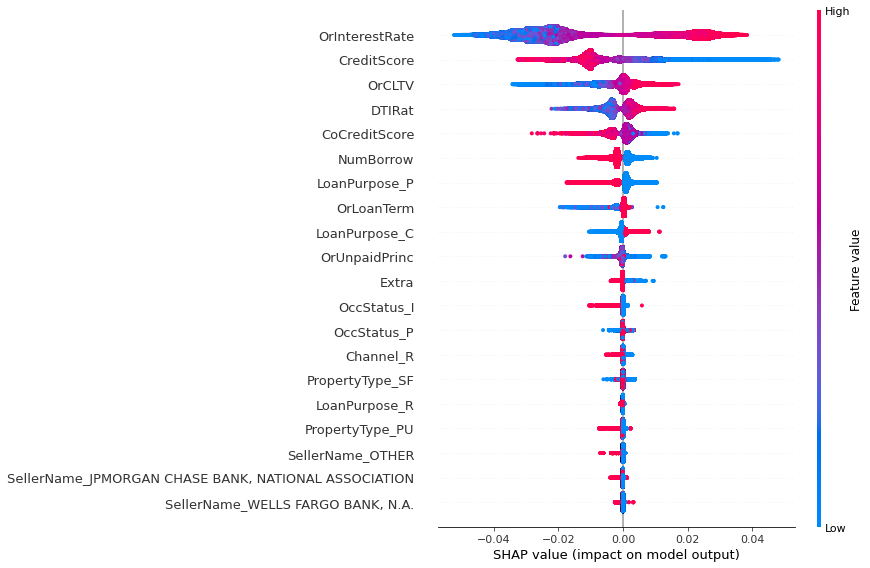

266.89933609962463 secs time


In [29]:
## shap Tree Explainer
start = time.time()
print('n_gpus',n_gpus)
if n_gpus == 0:
    model.set_param({"predictor": "cpu_predictor"})
else:
    model.set_param({"predictor": "gpu_predictor"})
expl = shap.TreeExplainer(model)
shap_values = expl.shap_values(X_test_df)
tshap = time.time()-start
print(time.time()-start,'secs time')
print(tshap)
print(shap_values.shape)
print(xgb.__version__)

start = time.time()
if n_gpus == 0: shap.summary_plot(shap_values, X_test_df)
else: shap.summary_plot(shap_values, X_test_df.to_pandas())
print(time.time()-start,'secs time')   

               RAPIDS GPU Acceleration of read_csv, merge, ML training,
                       ML inference, and Shapley ML Explanation


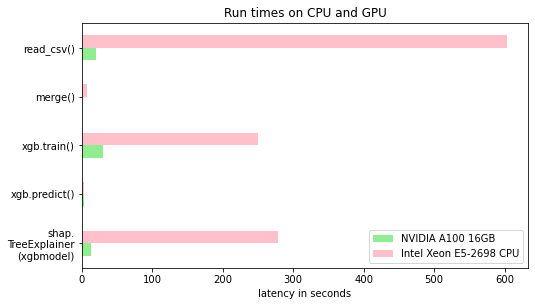

In [30]:
#from: https://developer.nvidia.com/blog/explaining-and-accelerating-machine-learning-for-loan-delinquencies/
#uses FNMA dataset for 2007-2012
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8,4.5]
#These timings are current as of Sep 2, 2020
data = [[603.0, 7.75, 250.1, 3.6, 278.9],
[20.6, .1, 30.0, 3.6, 12.5]]
#[tread, tmerg, ttrain, tpred, tshap]]
#[15.2, .1, 24.6, 2.4, 83.0]]

steps = ['read_csv()', 'merge()', 'xgb.train()', 'xgb.predict()', 'shap.\nTreeExplainer\n(xgbmodel)']
steps.reverse()
data[0].reverse()
data[1].reverse()
#data[2].reverse()
cpu = data[0]
v100 = data[1]
#a100 = data[2]
DF = pd.DataFrame({#'NVIDIA A100 GPU': a100,
                   'NVIDIA A100 16GB': v100,
                   'Intel Xeon E5-2698 CPU': cpu}, index=steps)
dict = {#"NVIDIA A100 GPU": "darkgreen",
    "NVIDIA A100 GPU": "lightgreen","CPU": "pink"}
ax = DF.plot.barh(color=dict.values())
ax.set_title('Run times on CPU and GPU')
ax.set_xlabel('latency in seconds')
print("               RAPIDS GPU Acceleration of read_csv, merge, ML training,")
print("                       ML inference, and Shapley ML Explanation")